# 14. Decision Tree 模型實驗

本實驗加入 Decision Tree 模型進行三高預測，並與現有模型（LR, RF, XGB, SVM, GP）比較。

## 實驗目的
1. 測試 Decision Tree 在三高預測的表現
2. 比較不同深度設定的影響
3. 提取可解釋的決策規則

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成")

套件載入完成


## 1. 載入資料

In [2]:
# 載入處理好的資料
data_path = Path('../../data/01_primary/SUA/processed/SUA_CVDs_wide_format.csv')
df = pd.read_csv(data_path)
print(f"資料形狀: {df.shape}")
print(f"\n欄位: {df.columns.tolist()}")

資料形狀: (6056, 107)

欄位: ['ID', 'sex', 'Age', 'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1', 'hypertension_T1', 'hyperglycemia_T1', 'dyslipidemia_T1', 'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2', 'hypertension_T2', 'hyperglycemia_T2', 'dyslipidemia_T2', 'FBG_T3', 'TC_T3', 'Cr_T3', 'UA_T3', 'GFR_T3', 'BMI_T3', 'SBP_T3', 'DBP_T3', 'hypertension_T3', 'hyperglycemia_T3', 'dyslipidemia_T3', 'FBG_T4', 'TC_T4', 'Cr_T4', 'UA_T4', 'GFR_T4', 'BMI_T4', 'SBP_T4', 'DBP_T4', 'hypertension_T4', 'hyperglycemia_T4', 'dyslipidemia_T4', 'FBG_T5', 'TC_T5', 'Cr_T5', 'UA_T5', 'GFR_T5', 'BMI_T5', 'SBP_T5', 'DBP_T5', 'hypertension_T5', 'hyperglycemia_T5', 'dyslipidemia_T5', 'FBG_T6', 'TC_T6', 'Cr_T6', 'UA_T6', 'GFR_T6', 'BMI_T6', 'SBP_T6', 'DBP_T6', 'hypertension_T6', 'hyperglycemia_T6', 'dyslipidemia_T6', 'FBG_T7', 'TC_T7', 'Cr_T7', 'UA_T7', 'GFR_T7', 'BMI_T7', 'SBP_T7', 'DBP_T7', 'hypertension_T7', 'hyperglycemia_T7', 'dyslipidemia_T7', 'FBG_T8', '

In [3]:
# 定義特徵（與 03_ModelBuilding.ipynb 一致）

# T1 特徵
t1_features = ['FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1']

# T2 特徵
t2_features = ['FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2']

# Delta 特徵
delta1_features = ['Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 
                   'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP']

# 人口統計特徵
demographic_features = ['sex', 'Age']

# 全部特徵
all_features = demographic_features + t1_features + t2_features + delta1_features

print(f"特徵總數: {len(all_features)} 個")
print(f"  - 人口統計: {len(demographic_features)} 個")
print(f"  - T1 特徵: {len(t1_features)} 個")
print(f"  - T2 特徵: {len(t2_features)} 個")
print(f"  - Δ1 特徵: {len(delta1_features)} 個")

特徵總數: 26 個
  - 人口統計: 2 個
  - T1 特徵: 8 個
  - T2 特徵: 8 個
  - Δ1 特徵: 8 個


In [4]:
# 目標變數
target_columns = ['hypertension_T3', 'hyperglycemia_T3', 'dyslipidemia_T3']

X = df[all_features]
y_hypertension = df['hypertension_T3']
y_hyperglycemia = df['hyperglycemia_T3']
y_dyslipidemia = df['dyslipidemia_T3']

print(f"\n高血壓 (hypertension_T3):")
print(y_hypertension.value_counts())
print(f"  患病率: {(y_hypertension == 2).mean():.2%}")

print(f"\n高血糖 (hyperglycemia_T3):")
print(y_hyperglycemia.value_counts())
print(f"  患病率: {(y_hyperglycemia == 2).mean():.2%}")

print(f"\n高血脂 (dyslipidemia_T3):")
print(y_dyslipidemia.value_counts())
print(f"  患病率: {(y_dyslipidemia == 2).mean():.2%}")


高血壓 (hypertension_T3):
1    5046
2    1010
Name: hypertension_T3, dtype: int64
  患病率: 16.68%

高血糖 (hyperglycemia_T3):
1    5721
2     335
Name: hyperglycemia_T3, dtype: int64
  患病率: 5.53%

高血脂 (dyslipidemia_T3):
1    5695
2     361
Name: dyslipidemia_T3, dtype: int64
  患病率: 5.96%


## 2. 資料準備

In [5]:
# 轉換為二元分類 (2 = 患病 -> 1, 其他 -> 0)
y_hypertension_binary = (y_hypertension == 2).astype(int)
y_hyperglycemia_binary = (y_hyperglycemia == 2).astype(int)
y_dyslipidemia_binary = (y_dyslipidemia == 2).astype(int)

# 合併為多標籤目標
y_multi = np.column_stack([y_hypertension_binary, y_hyperglycemia_binary, y_dyslipidemia_binary])

# 分割資料集
X_train, X_test, y_train_multi, y_test_multi = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_hypertension_binary
)

# 分離各疾病標籤
y_train_hp = y_train_multi[:, 0]
y_train_hg = y_train_multi[:, 1]
y_train_dl = y_train_multi[:, 2]

y_test_hp = y_test_multi[:, 0]
y_test_hg = y_test_multi[:, 1]
y_test_dl = y_test_multi[:, 2]

print(f"訓練集: {X_train.shape[0]} 人")
print(f"測試集: {X_test.shape[0]} 人")
print(f"特徵數: {X_train.shape[1]} 個")

訓練集: 4844 人
測試集: 1212 人
特徵數: 26 個


In [6]:
# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"訓練集形狀: {X_train_scaled.shape}")
print(f"測試集形狀: {X_test_scaled.shape}")

訓練集形狀: (4844, 26)
測試集形狀: (1212, 26)


## 3. Decision Tree 模型訓練

In [7]:
def train_and_evaluate_dt(X_train, X_test, y_train, y_test, disease_name, 
                          max_depth=None, class_weight=None, use_smote=False):
    """
    訓練並評估 Decision Tree 模型
    """
    # SMOTE 處理
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train_used, y_train_used = smote.fit_resample(X_train, y_train)
    else:
        X_train_used, y_train_used = X_train, y_train
    
    # 建立模型
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=42,
        min_samples_split=10,
        min_samples_leaf=5
    )
    
    # 訓練
    dt.fit(X_train_used, y_train_used)
    
    # 預測
    y_pred = dt.predict(X_test)
    y_prob = dt.predict_proba(X_test)[:, 1]
    
    # 評估指標
    results = {
        'disease': disease_name,
        'max_depth': max_depth,
        'class_weight': str(class_weight),
        'use_smote': use_smote,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'auc': roc_auc_score(y_test, y_prob),
        'tree_depth': dt.get_depth(),
        'n_leaves': dt.get_n_leaves()
    }
    
    return dt, results

In [8]:
# 測試不同深度設定
diseases = {
    '高血壓': (y_train_hp, y_test_hp),
    '高血糖': (y_train_hg, y_test_hg),
    '高血脂': (y_train_dl, y_test_dl)
}

depths = [3, 5, 7, 10, None]  # None = 不限制深度
all_results = []

for disease_name, (y_train, y_test) in diseases.items():
    print(f"\n=== {disease_name} ===")
    for depth in depths:
        dt, results = train_and_evaluate_dt(
            X_train_scaled, X_test_scaled,
            y_train, y_test,
            disease_name,
            max_depth=depth
        )
        all_results.append(results)
        print(f"  Depth={depth}: AUC={results['auc']:.3f}, Recall={results['recall']:.3f}, "
              f"實際深度={results['tree_depth']}, 葉節點={results['n_leaves']}")


=== 高血壓 ===
  Depth=3: AUC=0.749, Recall=0.054, 實際深度=3, 葉節點=8
  Depth=5: AUC=0.750, Recall=0.129, 實際深度=5, 葉節點=30
  Depth=7: AUC=0.733, Recall=0.158, 實際深度=7, 葉節點=74
  Depth=10: AUC=0.658, Recall=0.282, 實際深度=10, 葉節點=203
  Depth=None: AUC=0.650, Recall=0.282, 實際深度=19, 葉節點=325

=== 高血糖 ===
  Depth=3: AUC=0.865, Recall=0.342, 實際深度=3, 葉節點=8
  Depth=5: AUC=0.756, Recall=0.329, 實際深度=5, 葉節點=27
  Depth=7: AUC=0.770, Recall=0.342, 實際深度=7, 葉節點=52
  Depth=10: AUC=0.641, Recall=0.329, 實際深度=10, 葉節點=85
  Depth=None: AUC=0.733, Recall=0.355, 實際深度=15, 葉節點=102

=== 高血脂 ===
  Depth=3: AUC=0.834, Recall=0.026, 實際深度=3, 葉節點=8
  Depth=5: AUC=0.836, Recall=0.167, 實際深度=5, 葉節點=28
  Depth=7: AUC=0.819, Recall=0.192, 實際深度=7, 葉節點=70
  Depth=10: AUC=0.593, Recall=0.244, 實際深度=10, 葉節點=118
  Depth=None: AUC=0.691, Recall=0.205, 實際深度=16, 葉節點=158


In [9]:
# 整理結果表格
results_df = pd.DataFrame(all_results)
print("\n=== 不同深度的 Decision Tree 結果 ===")
display(results_df.pivot_table(
    index='max_depth', 
    columns='disease', 
    values=['auc', 'recall', 'f1'],
    aggfunc='mean'
).round(3))


=== 不同深度的 Decision Tree 結果 ===


auc                   f1               recall              
disease      高血壓    高血糖    高血脂    高血壓    高血糖    高血脂    高血壓    高血糖    高血脂
max_depth                                                               
3.0        0.749  0.865  0.834  0.096  0.433  0.048  0.054  0.342  0.026
5.0        0.750  0.756  0.836  0.193  0.385  0.250  0.129  0.329  0.167
7.0        0.733  0.770  0.819  0.218  0.380  0.254  0.158  0.342  0.192
10.0       0.658  0.641  0.593  0.316  0.352  0.299  0.282  0.329  0.244

## 4. 加入 class_weight 和 SMOTE

In [10]:
# 比較不同處理不平衡的方法
best_depth = 5  # 根據上面結果選擇

imbalance_results = []

for disease_name, (y_train, y_test) in diseases.items():
    print(f"\n=== {disease_name} ===")
    
    # 1. Baseline (無處理)
    dt, results = train_and_evaluate_dt(
        X_train_scaled, X_test_scaled, y_train, y_test,
        disease_name, max_depth=best_depth
    )
    results['method'] = 'Baseline'
    imbalance_results.append(results)
    print(f"  Baseline: AUC={results['auc']:.3f}, Recall={results['recall']:.3f}")
    
    # 2. class_weight='balanced'
    dt, results = train_and_evaluate_dt(
        X_train_scaled, X_test_scaled, y_train, y_test,
        disease_name, max_depth=best_depth, class_weight='balanced'
    )
    results['method'] = 'class_weight'
    imbalance_results.append(results)
    print(f"  class_weight: AUC={results['auc']:.3f}, Recall={results['recall']:.3f}")
    
    # 3. SMOTE
    dt, results = train_and_evaluate_dt(
        X_train_scaled, X_test_scaled, y_train, y_test,
        disease_name, max_depth=best_depth, use_smote=True
    )
    results['method'] = 'SMOTE'
    imbalance_results.append(results)
    print(f"  SMOTE: AUC={results['auc']:.3f}, Recall={results['recall']:.3f}")


=== 高血壓 ===
  Baseline: AUC=0.750, Recall=0.129
  class_weight: AUC=0.766, Recall=0.767
  SMOTE: AUC=0.741, Recall=0.609

=== 高血糖 ===
  Baseline: AUC=0.756, Recall=0.329
  class_weight: AUC=0.821, Recall=0.776
  SMOTE: AUC=0.830, Recall=0.711

=== 高血脂 ===
  Baseline: AUC=0.836, Recall=0.167
  class_weight: AUC=0.793, Recall=0.705
  SMOTE: AUC=0.794, Recall=0.615


In [11]:
# 整理不平衡處理結果
imbalance_df = pd.DataFrame(imbalance_results)
print("\n=== 不平衡處理方法比較 ===")
display(imbalance_df.pivot_table(
    index='method',
    columns='disease',
    values=['auc', 'recall'],
    aggfunc='mean'
).round(3))


=== 不平衡處理方法比較 ===


auc               recall              
disease         高血壓    高血糖    高血脂    高血壓    高血糖    高血脂
method                                                
Baseline      0.750  0.756  0.836  0.129  0.329  0.167
SMOTE         0.741  0.830  0.794  0.609  0.711  0.615
class_weight  0.766  0.821  0.793  0.767  0.776  0.705

## 5. 決策規則提取

In [12]:
# 訓練最終模型（以高血壓為例）
final_dt = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5
)
final_dt.fit(X_train_scaled, y_train_hp)

# 提取決策規則
rules = export_text(final_dt, feature_names=all_features)
print("=== 高血壓預測決策規則 ===")
print(rules[:2000])  # 只顯示前2000字元

=== 高血壓預測決策規則 ===
|--- SBP_T1 <= 0.54
|   |--- SBP_T2 <= 0.45
|   |   |--- DBP_T1 <= 1.00
|   |   |   |--- Delta1_SBP <= -1.51
|   |   |   |   |--- BMI_T2 <= -0.69
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BMI_T2 >  -0.69
|   |   |   |   |   |--- class: 1
|   |   |   |--- Delta1_SBP >  -1.51
|   |   |   |   |--- SBP_T2 <= -0.54
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SBP_T2 >  -0.54
|   |   |   |   |   |--- class: 0
|   |   |--- DBP_T1 >  1.00
|   |   |   |--- Delta1_TC <= 0.58
|   |   |   |   |--- SBP_T2 <= -0.39
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SBP_T2 >  -0.39
|   |   |   |   |   |--- class: 1
|   |   |   |--- Delta1_TC >  0.58
|   |   |   |   |--- Delta1_BMI <= 0.63
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Delta1_BMI >  0.63
|   |   |   |   |   |--- class: 1
|   |--- SBP_T2 >  0.45
|   |   |--- Delta1_GFR <= 0.02
|   |   |   |--- GFR_T1 <= -0.58
|   |   |   |   |--- Delta1_FBG <= -1.40
|   |   |   |   |   |--- class: 1


=== 特徵重要性 (Top 10) ===


,feature,importance
8,SBP_T1,0.488139
16,SBP_T2,0.236063
24,Delta1_SBP,0.053372
9,DBP_T1,0.046510
6,GFR_T1,0.042760
15,BMI_T2,0.023972
23,Delta1_BMI,0.019106
22,Delta1_GFR,0.018764
19,Delta1_TC,0.009645
2,FBG_T1,0.009375


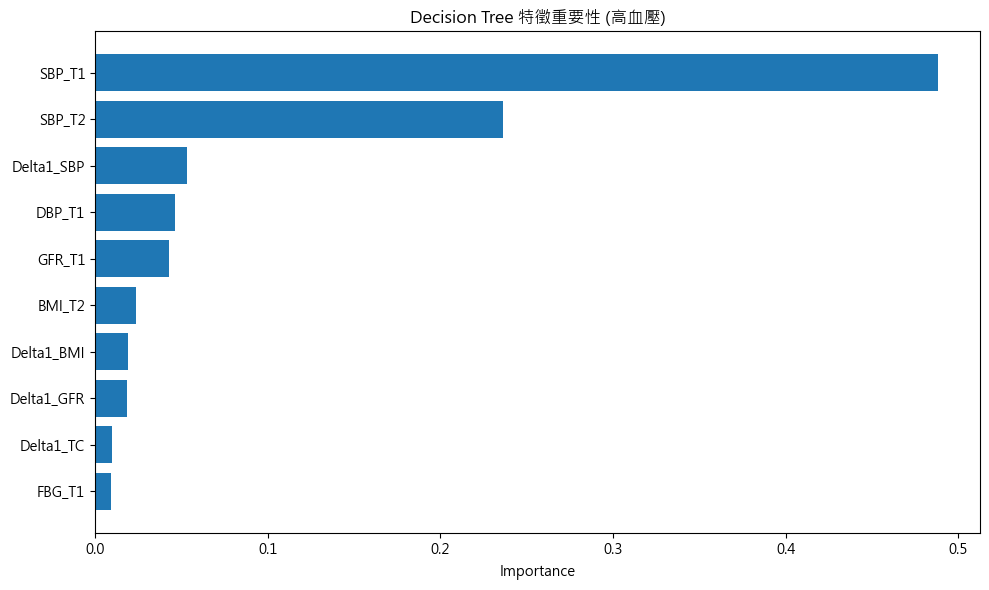

In [19]:
# 特徵重要性
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': final_dt.feature_importances_
}).sort_values('importance', ascending=False)

print("=== 特徵重要性 (Top 10) ===")
display(feature_importance.head(10))

# 視覺化
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance')
ax.set_title('Decision Tree 特徵重要性 (高血壓)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../../results/figures/dt_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 與其他模型比較

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 比較模型
comparison_results = []

for disease_name, (y_train, y_test) in diseases.items():
    print(f"\n=== {disease_name} ===")
    
    # SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
    
    # Decision Tree
    dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
    dt.fit(X_train_smote, y_train_smote)
    y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]
    y_pred_dt = dt.predict(X_test_scaled)
    
    comparison_results.append({
        'disease': disease_name,
        'model': 'Decision Tree',
        'auc': roc_auc_score(y_test, y_prob_dt),
        'recall': recall_score(y_test, y_pred_dt),
        'precision': precision_score(y_test, y_pred_dt, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt)
    })
    
    # Logistic Regression
    lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
    lr.fit(X_train_smote, y_train_smote)
    y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]
    y_pred_lr = lr.predict(X_test_scaled)
    
    comparison_results.append({
        'disease': disease_name,
        'model': 'Logistic Regression',
        'auc': roc_auc_score(y_test, y_prob_lr),
        'recall': recall_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr)
    })
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf.fit(X_train_smote, y_train_smote)
    y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]
    y_pred_rf = rf.predict(X_test_scaled)
    
    comparison_results.append({
        'disease': disease_name,
        'model': 'Random Forest',
        'auc': roc_auc_score(y_test, y_prob_rf),
        'recall': recall_score(y_test, y_pred_rf),
        'precision': precision_score(y_test, y_pred_rf, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf)
    })


=== 高血壓 ===

=== 高血糖 ===

=== 高血脂 ===


In [21]:
# 整理比較結果
comparison_df = pd.DataFrame(comparison_results)
print("\n=== 模型比較結果 ===")
display(comparison_df.pivot_table(
    index='model',
    columns='disease',
    values=['auc', 'recall'],
    aggfunc='mean'
).round(3))


=== 模型比較結果 ===


auc               recall              
disease                高血壓    高血糖    高血脂    高血壓    高血糖    高血脂
model                                                        
Decision Tree        0.741  0.826  0.793  0.609  0.711  0.615
Logistic Regression  0.748  0.931  0.887  0.683  0.829  0.821
Random Forest        0.788  0.902  0.853  0.356  0.487  0.308

## 7. 結論

### Decision Tree 優點
1. **可解釋性強**：可直接提取決策規則
2. **不需標準化**：對特徵縮放不敏感（但為了與其他模型比較，仍使用標準化資料）
3. **處理速度快**：訓練和預測都很快

### Decision Tree 缺點
1. **容易過擬合**：需要限制深度
2. **對不平衡資料敏感**：需要 class_weight 或 SMOTE
3. **單一樹不穩定**：Random Forest 更穩健

### 建議
- 使用 Decision Tree 來**理解特徵關係**和**提取規則**
- 實際預測仍建議使用 **Random Forest** 或 **XGBoost**

In [22]:
# 儲存結果
results_df.to_csv('../../results/tables/dt_depth_comparison.csv', index=False)
imbalance_df.to_csv('../../results/tables/dt_imbalance_comparison.csv', index=False)
comparison_df.to_csv('../../results/tables/dt_model_comparison.csv', index=False)
feature_importance.to_csv('../../results/tables/dt_feature_importance.csv', index=False)

print("結果已儲存到 results/tables/")

結果已儲存到 results/tables/
